In [6]:
%matplotlib inline

import scipy as sp
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def k(p, q, scale=1):
    return sp.exp(-(sp.spatial.distance.cdist(p, q)/scale)**2)

def plot_many(xs, ys):
    for y in ys:
        plt.plot(xs, y)
    
    plt.ylim(-3, +3)
    plt.xlim(xs.min(), xs.max())
    plt.xlabel('x')
    plt.ylabel('f(x)')

sns.set_context(rc={'figure.figsize': (15, 8)})

 ### A Constructive Approach to Gaussian Processes
 
Gaussian processes give you a way to pick a 'nice' function at random. By a 'nice' function, I mean smooth ones, like these: 

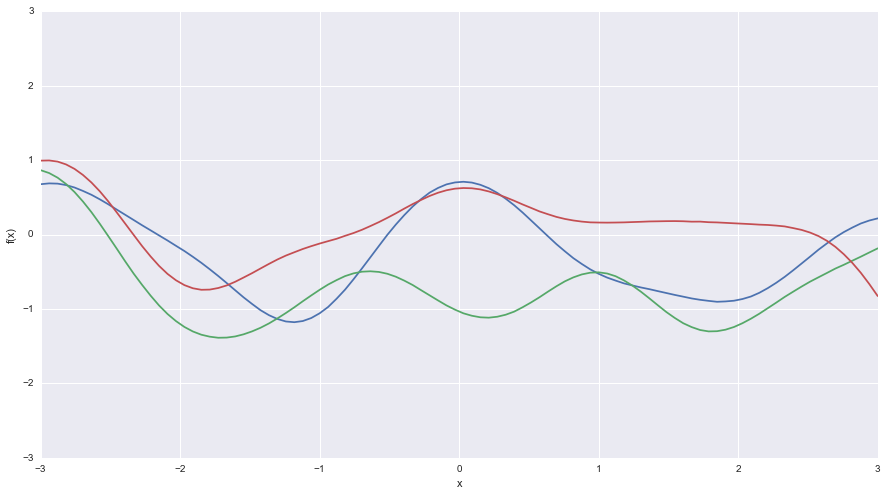

In [9]:
xs = sp.linspace(-3, 3, 100)[:, None]

K = k(xs, xs)
ys = sp.random.multivariate_normal(sp.zeros(len(xs)), K + 1e-6*sp.eye(len(xs)), size=3)
plot_many(xs, ys)

Gaussian processes also let you pick a nice function that is guaranteed to have certain values. Here're three random  functions where $f(-1) = f(+1) = 0$:

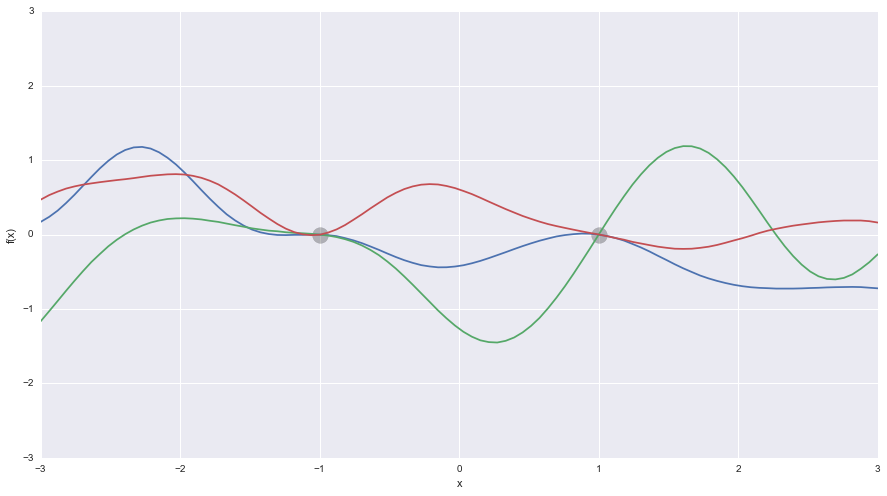

In [10]:
x0 = sp.array([[-1], [1]])
y0 = sp.array([0, 0])

xs = sp.linspace(-3, 3, 100)[:, None]

def condition(x0, y0, xs):
    V11 = k(xs, xs)
    V12 = k(xs, x0)
    V22 = k(x0, x0)
    
    m = V12.dot(sp.linalg.inv(V22)).dot(y0)
    K = V11 - V12.dot(sp.linalg.inv(V22)).dot(V12.T)
    
    return m.flatten(), K + 1e-6*sp.eye(len(xs)) 

m, K = condition(x0, y0, xs)

ys = sp.random.multivariate_normal(m, K, size=3)

plot_many(xs, ys)
plt.scatter(x0, y0, s=250, alpha=0.25, c='k')

How does it work?

### Starting Simple

Rather than pick functions at random, let's start by picking piecewise linear approximations to functions. Here's a piecewise linear approximation of the $\sin$ function, with linear pieces $1$ unit long: 

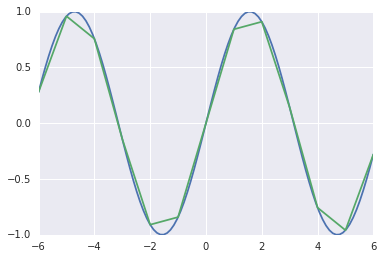

In [89]:
x1 = sp.linspace(-6, +6, 100)
y1 = sp.sin(x1)
 
x2 = sp.linspace(-6, +6, 13)
y2 = sp.sin(x2)

plt.plot(x1, y1)
plt.plot(x2, y2)

What's an easy way to pick a piecewise-linear approximation at random? Well, we could just independently pick the $y$-value for the ends of each straight piece from $\mathcal{N}(0, 1)$:

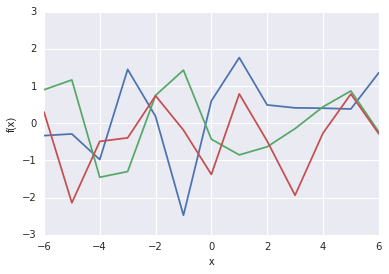

In [88]:
xs = sp.linspace(-6, +6, 13)
ys = sp.random.multivariate_normal(sp.zeros_like(xs), sp.eye(len(xs)), size=3)
plot_many(xs, ys)

but those don't look like they approximate very nice functions.  

What's missing is that if $f$ is a nice function, then when $x_1$ is close to $x_2$, we expect $y_1 = f(x_1)$ to be similar to $y_2 = f(x_2)$. In statistics, the usual way to say that two random variables are similar is to say they *covary*. So when $x_1$ is close to $x_2$, the covariance between $y_1$ and $y_2$ should be high. Conversely, when $x_1$ is a long way from $x_2$, the covariance between $y_1$ and $y_2$ should be low.

Here's some *covariance functions* (also known as a *kernels*) that reflect what we've just said:

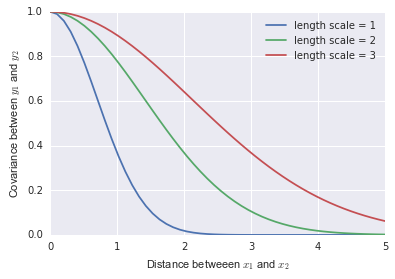

In [63]:
xs = sp.linspace(0, 5)

y1 = sp.exp(-xs**2)
plt.plot(xs, y1)

y2 = sp.exp(-(xs/2)**2)
plt.plot(xs, y2)

y3 = sp.exp(-(xs/3)**2)
plt.plot(xs, y3)

plt.legend(['length scale = {}'.format(1), 'length scale = {}'.format(2), 'length scale = {}'.format(3)])
plt.xlabel('Distance betweeen $x_1$ and $x_2$')
plt.ylabel('Covariance between $y_1$ and $y_2$')

These are all *squared exponential* covariance functions. A covariance function can have any shape - as long as it's positive - but the squared exponential functions are by far the most popular, because they're nice to work with. The three functions above differ in their *length scale*, which says how far apart $x_1$ and $x_2$ need to be before you no longer expect $y_1$ and $y_2$ to be similar. The longer the length scale, the greater this distance is.

Anyway, let's pick the covariance function with length scale $2$ and calculate the covariance for all the points in our linear approximation:

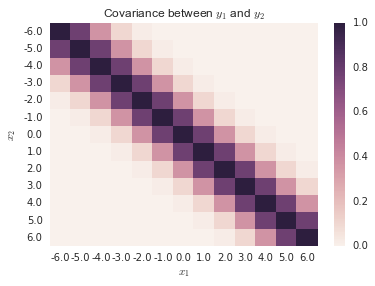

In [87]:
xs = sp.linspace(-6, +6, 13)[:, None]

K = k(xs, xs, 2)

sns.heatmap(pd.DataFrame(K, columns=xs.flatten(), index=xs.flatten()))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Covariance between $y_1$ and $y_2$')

This is a *covariance matrix* for our $y_i$'s. So now, rather than pick each $y_i$ independently from $\mathcal{N}(0, 1)$, we can pick them all at the same time from $\mathcal{N}(\mathbf{0}, \mathbf{K})$, where $\mathbf{K}$ is the covariance matrix above:

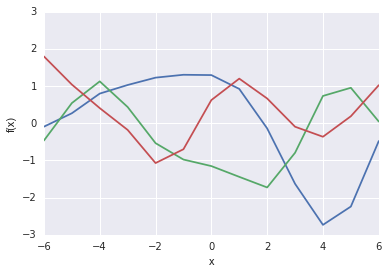

In [91]:
xs = sp.linspace(-6, +6, 13)[:, None]

K = k(xs, xs, 2)
ys = sp.random.multivariate_normal(sp.zeros(len(xs)), K, size=3)

plot_many(xs, ys)

These functions look a lot nicer than the old ones, but I still wouldn't call them 'nice'. The final step is to up the resolution of the linear approximation. The pieces in the chart above are $1$ unit long. If we drop that down to $0.25$, we get

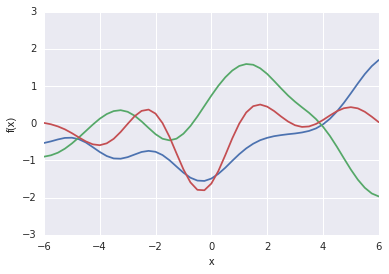

In [102]:
xs = sp.linspace(-6, +6, 12/0.25 + 1)[:, None]

K = k(xs, xs, 2) + 1e-6*sp.eye(len(xs))
ys = sp.random.multivariate_normal(sp.zeros(len(xs)), K, size=3)

plot_many(xs, ys)